In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(12046)

In [2]:
sequence_len = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# softmax对于-inf的计算结果
a = torch.tensor([1, 2, float('-inf')]).float()
F.softmax(a)

<ipython-input-4-b8ef0cee3ff2>:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(a)


tensor([0.2689, 0.7311, 0.0000])

In [9]:
# K: (B, T, H)
# Q: (B, T, H)
# K @ Q.transpose(-2, -1): (B, T, T)
scores = torch.randn(2, 4, 4)
scores

tensor([[[-0.0279,  0.0344,  1.5538, -1.7431],
         [-0.4989, -0.3522,  1.1061,  0.3697],
         [-0.9631,  0.5884, -1.6374,  1.3192],
         [ 0.5184, -0.6736, -1.0386, -0.0472]],

        [[-0.9193, -0.3242, -0.6820,  0.5801],
         [-0.1038, -0.1631,  0.8468,  2.2264],
         [ 2.2772,  2.2799, -1.6827, -0.0620],
         [-1.3304, -0.7853,  0.2966, -1.3182]]])

In [10]:
# 定义下三角矩阵
tril = torch.tril(torch.ones(4, 4))
s = scores.masked_fill(tril == 0, float('-inf'))
s

tensor([[[-0.0279,    -inf,    -inf,    -inf],
         [-0.4989, -0.3522,    -inf,    -inf],
         [-0.9631,  0.5884, -1.6374,    -inf],
         [ 0.5184, -0.6736, -1.0386, -0.0472]],

        [[-0.9193,    -inf,    -inf,    -inf],
         [-0.1038, -0.1631,    -inf,    -inf],
         [ 2.2772,  2.2799, -1.6827,    -inf],
         [-1.3304, -0.7853,  0.2966, -1.3182]]])

In [11]:
# 定义权重分布
F.softmax(s, dim=-1)

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4634, 0.5366, 0.0000, 0.0000],
         [0.1606, 0.7576, 0.0818, 0.0000],
         [0.4802, 0.1458, 0.1012, 0.2728]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [0.5148, 0.4852, 0.0000, 0.0000],
         [0.4946, 0.4959, 0.0094, 0.0000],
         [0.1133, 0.1954, 0.5766, 0.1147]]])

In [12]:
# softmax对方差的敏感性
x = torch.randn(1, 8)
x.std(), F.softmax(x, dim=-1)

(tensor(1.1269),
 tensor([[0.0585, 0.0270, 0.0154, 0.1657, 0.2518, 0.0739, 0.3735, 0.0342]]))

In [13]:
F.softmax(1000 * x, dim=-1)

tensor([[0., 0., 0., 0., 0., 0., 1., 0.]])

In [15]:
# 对齐分数的方差变化
B, T, H =32, 100, 10
K = torch.randn(B, T, H)
Q = torch.randn(B, T, H)
scores = K @ Q.transpose(-2, -1) / H ** 0.5
scores.std()

tensor(0.9953)

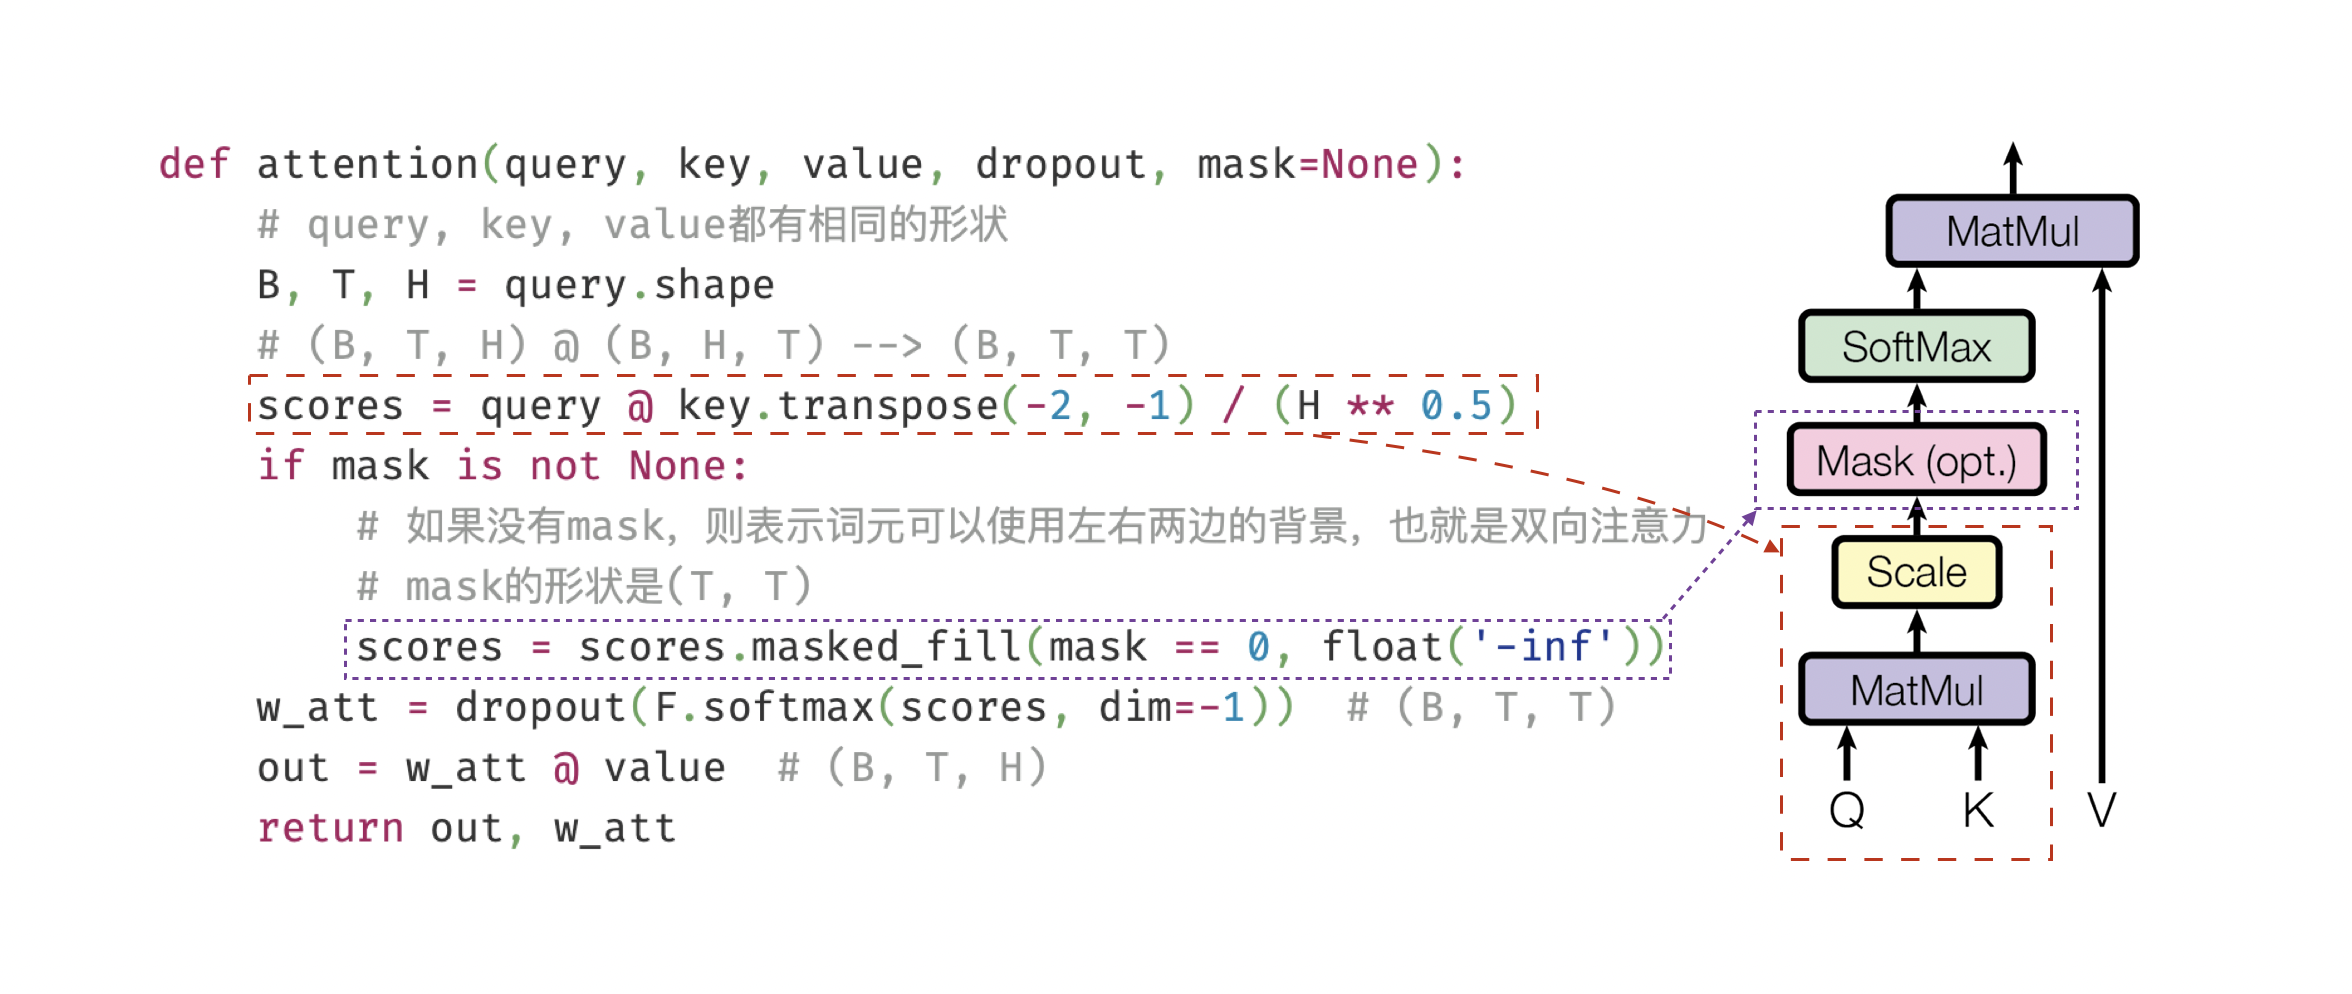

In [16]:
def attention(query, key, value, dropout, mask=None):
    # query, key, value: (B, T, H)
    # mask:                 (T, T)
    # output:            (B, T, H)
    B, T, H = query.shape
    scores = query @ key.transpose(-2, -1) / H ** 0.5
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))
    w_att = F.softmax(scores, dim=-1)  # (B, T, T)
    out = w_att @ value                # (B, T, H)
    return out

In [17]:
class MaskedAttention(nn.Module):
    # 单向自注意力
    
    def __init__(self, emb_size, head_size):
        # emb_size: C, head_size: H
        super().__init__()
        self.key = nn.Linear(emb_size, head_size, bias=False)
        self.query = nn.Linear(emb_size, head_size, bias=False)
        self.value = nn.Linear(emb_size, head_size, bias=False)
        # 定义下三角矩阵
        self.register_buffer('tril', torch.tril(torch.ones(sequence_len, sequence_len)))
        self.dp = nn.Dropout(0.4)
        
    def forward(self, x):
        # x:   (B, T, C)
        # out: (B, T, H)
        B, T, C = x.shape
        k = self.key(x)    # (B, T, H)
        q = self.query(x)  # (B, T, H)
        v = self.value(x)  # (B, T, H)
        mask = self.tril[:T, :T]
        out = attention(q, k, v, self.dp, mask)
        return out

In [18]:
m = MaskedAttention(3, 4)
x = torch.randn(5, 10, 3)
m(x).shape

torch.Size([5, 10, 4])